In [1]:
import numpy as np
import scipy
import time
from scipy.sparse import diags
from sklearn.datasets import load_svmlight_file
np.random.seed(11)
from IPython import display
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import optimization
import oracles
from utils import get_line_search_tool

# Tests

In [3]:
### Hess_vec test
np.random.seed(11)
A = np.random.uniform(0, 100, (5, 5))
b = np.random.uniform(0, 100, 5)
regcoef = np.random.uniform(0, 10, 1)
oracle = oracles.create_log_reg_oracle(A, b, regcoef)

diff_arr = []
# Проверка hess_vec из модуля oracle и logrec из 5 точек
for i in range(5):
  np.random.seed(11 + i)
  x = np.random.uniform(0, 100, 5)
  v = np.random.uniform(0, 100, 5)
  hess_vec_finite = oracles.hess_vec_finite_diff(oracle.func, x, v).reshape((5,))
  hess_vec_oracle = oracle.hess_vec(x, v)
  diff_arr.append(np.abs(np.subtract(hess_vec_finite, hess_vec_oracle)).sum()/np.shape(x))
print("Avg element-wise abs error: ", sum(diff_arr)[0]/5)


Avg element-wise abs error:  0.0632529721291533


In [4]:
list(zip(hess_vec_finite, hess_vec_oracle))

[(212.93089957907793, 212.88862506944864),
 (122.92730389162897, 122.8804334311478),
 (122.34522728249429, 122.30018902730941),
 (44.89265847951173, 44.88384255539063),
 (100.40821507573126, 100.37855640843489)]

# Experiments

In [5]:
from scipy.sparse import diags
def experiment_1():
  np.random.seed(11)
  ns_arr = [10, 100, 1000, 10000]
  colors = ['r', 'b', 'g', 'm']

  k_arr = list(range(1, 1000, 100))
  iters_for_k = 3

  T = {}

  for n, color in zip(ns_arr, colors):
    T[n] = [[] for _ in range(iters_for_k)]
    for i in range(iters_for_k):
      for k in k_arr:
          diag = np.random.uniform(low=1, high=k, size=n)
          diag[0], diag[-1] = 1, k
          A = diags(diag)
          b = np.random.uniform(low=1, high=k, size=n)
          matvec = lambda x: A @ x
          x_star, msg, history = optimization.conjugate_gradients(matvec, b, np.zeros(n), trace=True)
          T[n][i].append(len(history['time']))

      plt.plot(k_arr, T[n][i], ls='dashdot', color=color, alpha=0.3)

    plt.plot(k_arr, np.mean(T[n], axis=0), color=color, label='n = {}'.format(n))

  plt.grid()
  plt.legend()
  plt.ylabel('iterations')
  plt.xlabel('k')
  plt.show()

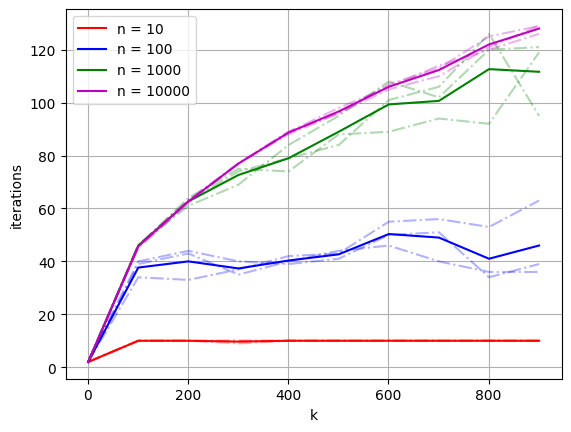

In [6]:
experiment_1()

In [7]:
from scipy.sparse import diags
def experiment_1_old():
  np.random.seed(11)
  ns_arr = [10, 100, 1000, 10000]
  colors = ['r', 'b', 'g', 'm']

  k_arr = list(range(1, 1000, 100))
  iters_for_k = 3

  T = {}

  for n, color in zip(ns_arr, colors):
    T[n] = [[] for _ in range(iters_for_k)]
    for i in range(iters_for_k):
      for k in k_arr:
          diag = np.random.uniform(low=1, high=k, size=n)
          diag[0], diag[-1] = 1, k
          A = diags(diag)
          b = np.random.uniform(low=1, high=k, size=n)
          oracle = oracles.QuadraticOracle(A, b)
          x_star, msg, history = optimization.gradient_descent(oracle, np.zeros(n),line_search_options={'method': 'Armijo'},
                                                                trace=True)
          T[n][i].append(len(history['grad_norm']))

      plt.plot(k_arr, T[n][i], ls='dashdot', color=color, alpha=0.3)

    plt.plot(k_arr, np.mean(T[n], axis=0), color=color, label='n = {}'.format(n))

  plt.grid()
  plt.legend()
  plt.ylabel('iterations')
  plt.xlabel('k')
  plt.show()

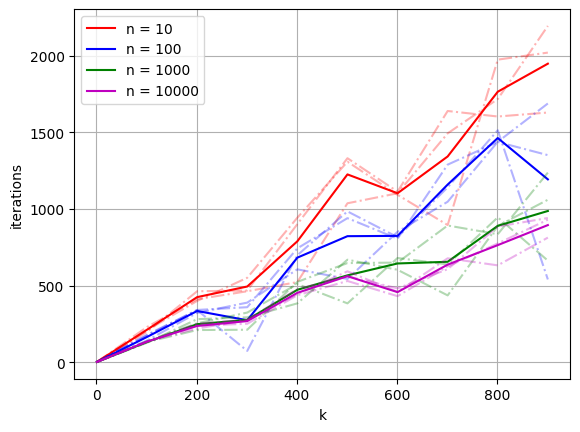

In [8]:
experiment_1_old()

In [9]:

def experiment_2():

  def iter_over_mem_size(l_arr):
    result = []
    for l in l_arr:
      _, _, history = optimization.lbfgs(oracle, np.zeros(n), memory_size=l, trace=True)
      g_norm = np.array(history['grad_norm'])
      g_norm /= g_norm[0]
      g_norm = np.power(g_norm, 2)
      g_norm = np.log(g_norm)
      result.append((g_norm, history['time'], l))
    return result

  def log_grad_norm_vs_time(result):
    for g_norm, time, l  in result:
      x = time
      plt.plot(x, g_norm, label='history size = {}'.format(l))
    plt.xlabel('Секунд')
    plt.ylabel('Относительныая норма квадрата градиента')
    plt.legend()
    plt.grid()
    plt.show()

  def log_grad_norm_vs_iters(result):
    for g_norm, time, l in result:
      x = list(range(len(g_norm)))
      plt.plot(x, g_norm, label='history size = {}'.format(l))
    plt.xlabel('Итераций')
    plt.ylabel('Относительныая норма квадрата градиента')
    plt.legend()
    plt.grid()
    plt.show()

  data_path = '/content/drive/MyDrive/Colab Notebooks/Optimiz/Lab 2/datasets/gisette_scale'
  A, b = load_svmlight_file(data_path)
  m, n = A.shape
  oracle = oracles.create_log_reg_oracle(A, b, 1/m)

  l_arr = [0, 1, 5, 10, 50, 100]
  res = iter_over_mem_size(l_arr)

  log_grad_norm_vs_iters(res)
  log_grad_norm_vs_time(res)


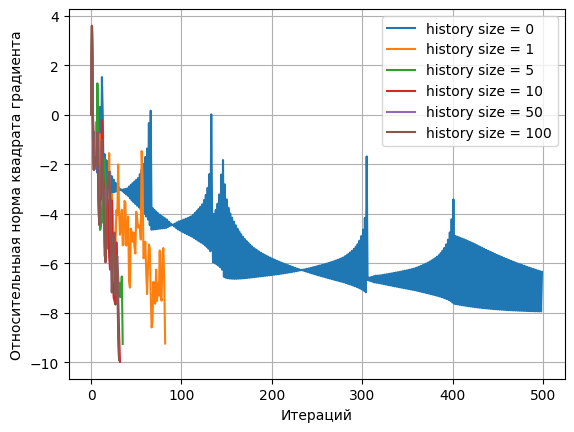

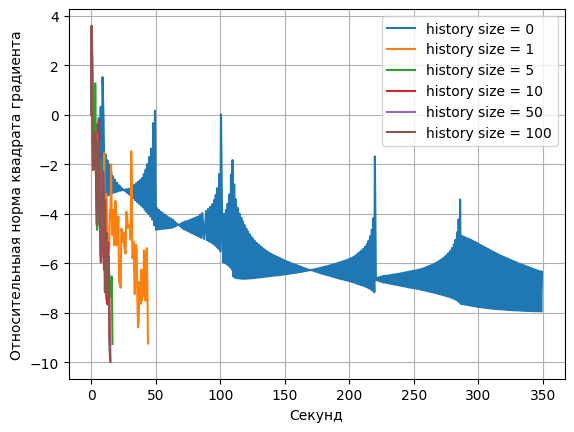

In [10]:
experiment_2()

In [35]:
#import os
#os.chdir('/content/drive/MyDrive/Colab Notebooks/Optimiz/Lab 2')
def experiment_3():
  data_path = '/content/drive/MyDrive/Colab Notebooks/Optimiz/Lab 2/datasets/'
  dataSetsNames = [
        'w8a.txt',
        'gisette_scale',
        'real-sim',
        'news20.binary',
        'rcv1_train.binary',
    ]

  def iter_over_method(oracle):
    fun_arr = [optimization.hessian_free_newton, optimization.lbfgs, optimization.gradient_descent]
    result = []
    for fun in fun_arr:
      _, _, history = fun(oracle, np.zeros(n), trace=True)
      g_norm = np.array(history['grad_norm'])
      g_norm /= g_norm[0]
      g_norm = np.power(g_norm, 2)
      g_norm = np.log(g_norm)
      result.append((history['func'], g_norm, history['time'], fun.__name__))
    return result

  def draw_plots(result):
    def fun_vs_time(result):
      for func, g_norm, time, method in result:
        x = time
        plt.plot(x, func, label='Method = {}'.format(method))
      plt.ylabel('Значение функции')
      plt.xlabel('Секунды')
      plt.legend()
      plt.grid()
      plt.show()

    def fun_vs_iter(result):
      for func, g_norm, time, method in result:
        plt.plot(list(range(len(func))), func, label='Method = {}'.format(method))
      plt.ylabel('Значение функции')
      plt.xlabel('Итерация')
      plt.legend()
      plt.grid()
      plt.show()

    def sqr_norm_grad_vs_time(result):
      for func, g_norm, time, method in result:
        plt.plot(time, g_norm, label='Method = {}'.format(method))
      plt.ylabel('Относительныая норма квадрата градиента')
      plt.xlabel('Время')
      plt.legend()
      plt.grid()
      plt.show()

    fun_vs_time(result)
    fun_vs_iter(result)
    sqr_norm_grad_vs_time(result)


  for dataset in dataSetsNames:
    print(dataset)
    A, b = load_svmlight_file(data_path+dataset)
    m, n = A.shape
    oracle = oracles.create_log_reg_oracle(A, b, 1 / m)
    res = iter_over_method(oracle)
    draw_plots(res)

w8a.txt


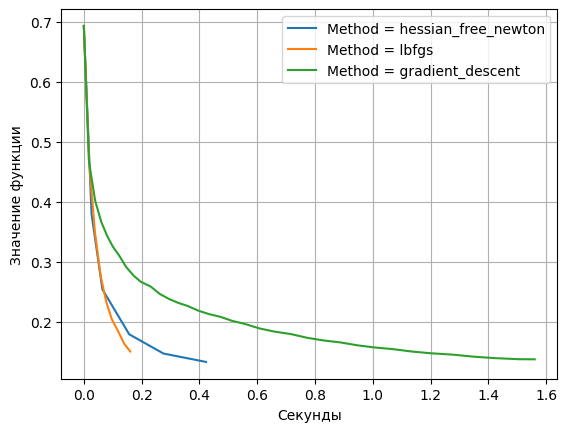

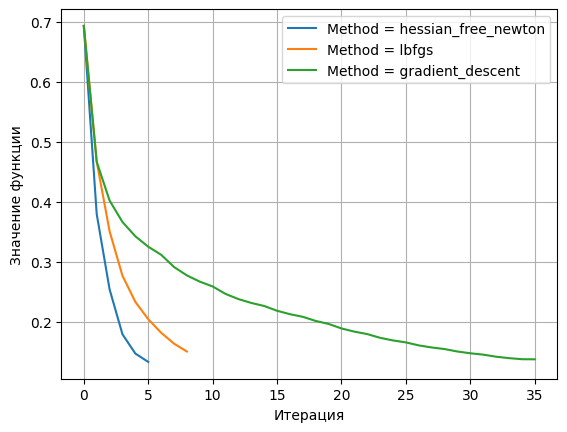

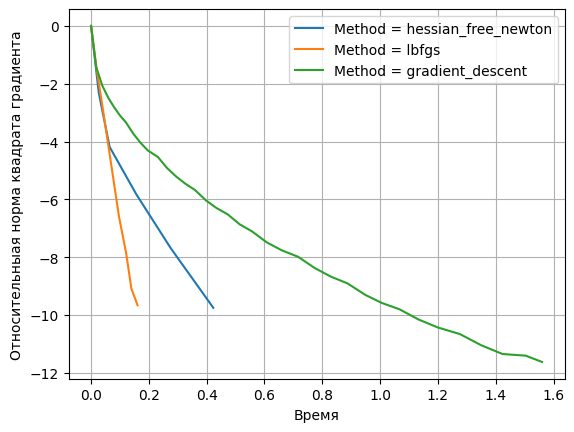

gisette_scale


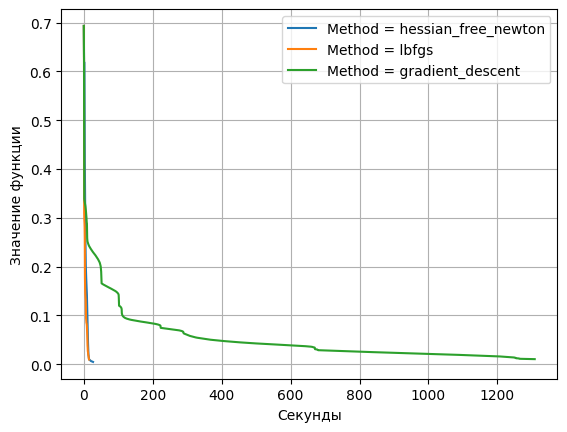

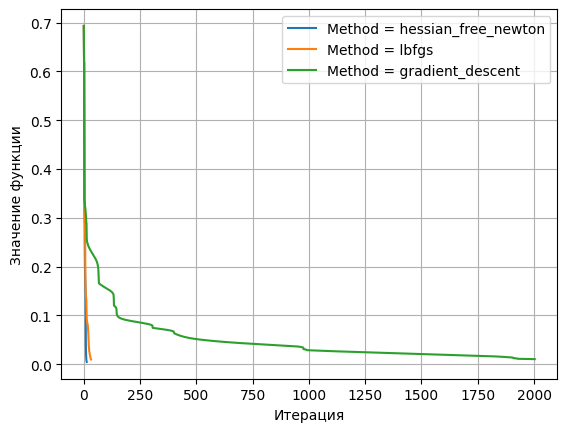

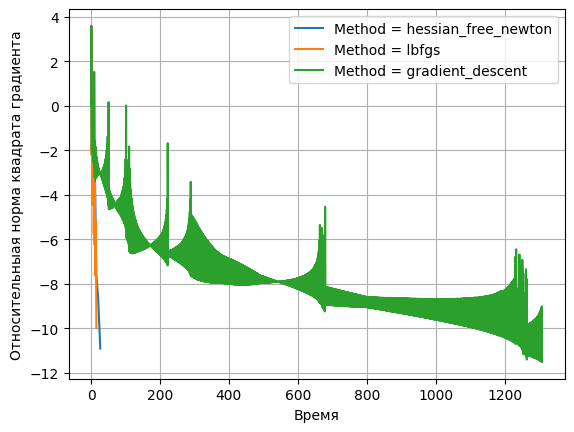

real-sim


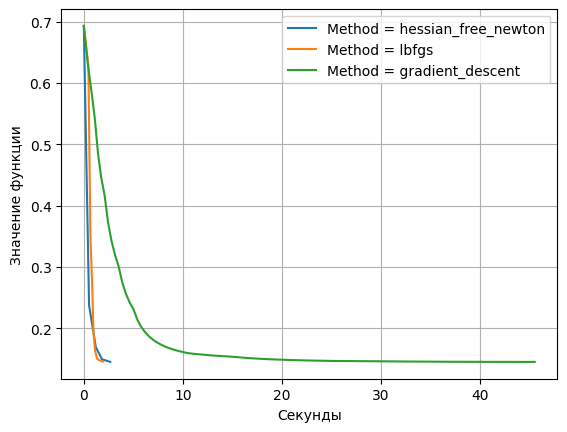

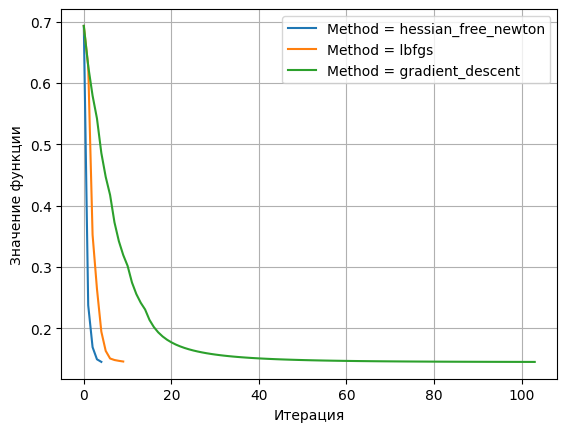

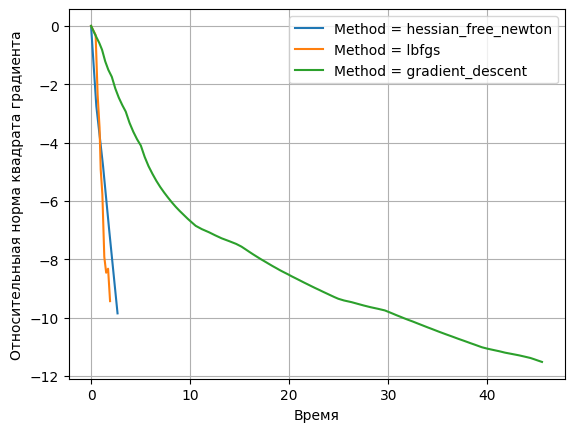

news20.binary


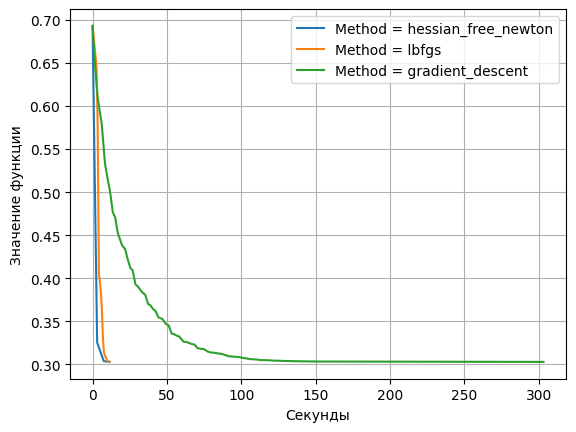

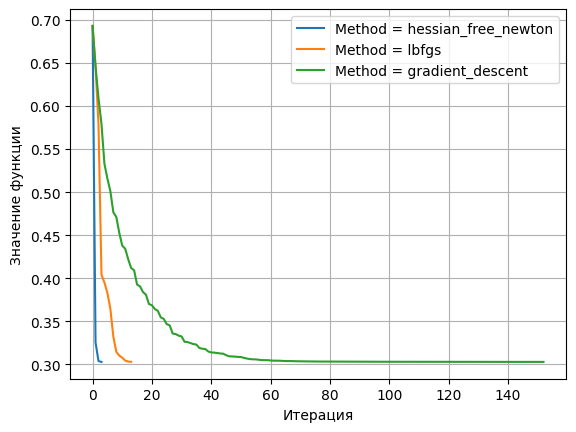

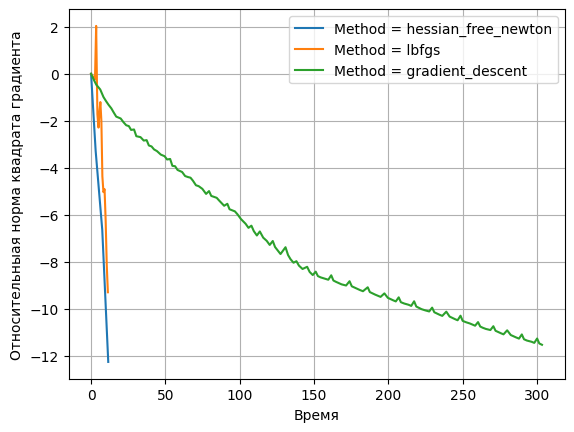

rcv1_train.binary


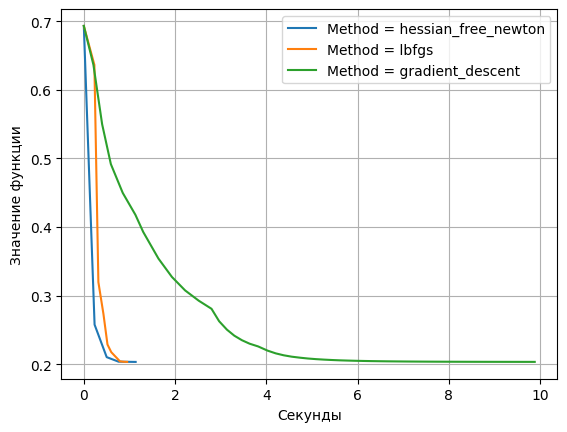

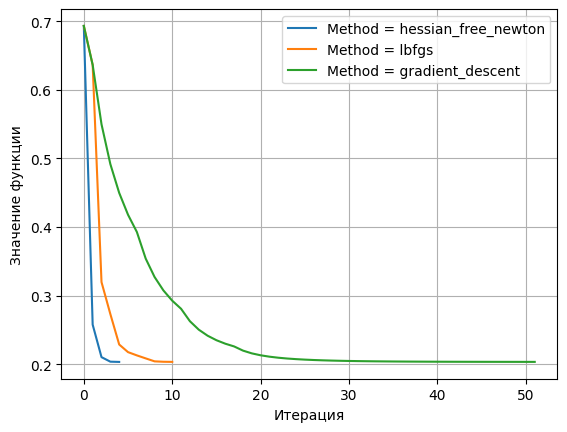

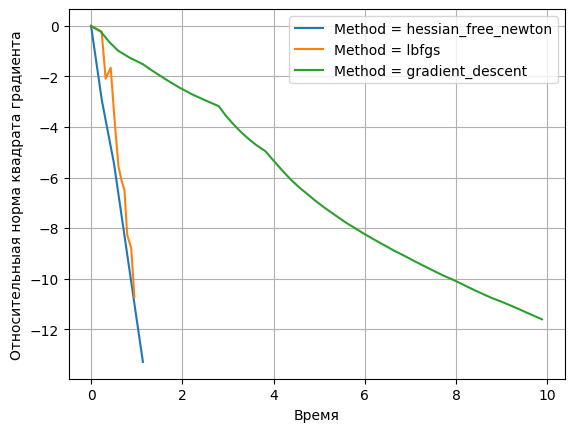

In [36]:
experiment_3()

In [59]:
from sklearn.datasets import make_spd_matrix # Импорт положительно определенной симетричной матрицы
# The Hessian matrix of a convex function is positive semi-definite.
# Hessian of Quadratic func = A

def experiment_4():
  ### r_k = A*x_k-b = g_k
  def grad_norm_vs_iter(history_LBFGS, history_CG):

    g_norm = np.array(history_LBFGS['grad_norm'])
    g_norm = np.log(g_norm)
    plt.plot(list(range(len(g_norm))), g_norm, label='L-BFGS')
    plt.plot(list(range(len(history_CG['residual_norm']))), history_CG['residual_norm'], label='Conjugate gradients')

    plt.ylabel('Евклидова норма невязки в лог шкале')
    plt.xlabel('Итерации', labelpad = 5)
    plt.legend()
    plt.grid()
    plt.show()

  np.random.seed(11)
  k = 10
  n = 20
  A = np.array(make_spd_matrix(n_dim=n, random_state=11))
  b = np.random.uniform(low=-k, high = k, size=n)
  oracle = oracles.QuadraticOracle(A, b)

  matvec = lambda x: A @ x

  history_arr = []

  _, _, history_CG = optimization.conjugate_gradients(matvec, b, np.zeros(n), trace=True)
  _, _, history_LBFGS = optimization.lbfgs(oracle, np.zeros(n), trace=True, memory_size=0, line_search_options={'method': 'Best'})
  grad_norm_vs_iter(history_LBFGS, history_CG)



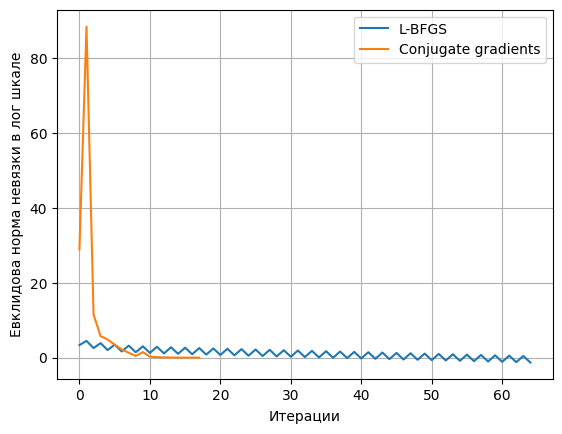

In [60]:
experiment_4() # С точным шагом и памятью l = 0

In [17]:
[np.power(10,x) for x in np.arange(0,-7,-1, dtype=float)]

[1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06]

In [18]:
def experiment_5():
  data_path = '/content/drive/MyDrive/Colab Notebooks/Optimiz/Lab 2/datasets/'
  dataSetsNames_Train = [
        'w8a.txt',
        'gisette_scale'
    ]
  dataSetsNames_Test = [
        'w8a_test.txt',
        'gisette_scale.t'
    ]

  for dataset_train, dataset_test in zip(dataSetsNames_Train, dataSetsNames_Test):
    print(dataset_train)
    A_train, b_train = load_svmlight_file(data_path + dataset_train)
    m_train, n_train = A_train.shape
    oracle = oracles.create_log_reg_oracle(A_train, b_train, 1 / m_train)

    A_test, b_test = load_svmlight_file(data_path + dataset_test)
    m_test, n_test = A_train.shape

    correct_arr = []
    eps_arr = [np.power(10,x) for x in np.arange(0,-7,-1, dtype=float)]

    for eps in eps_arr:
      x_, _, _ = optimization.lbfgs(oracle, np.zeros(n_train),tolerance=eps) # ,tolerance=1e-9

      b_ = np.sign(A_test.dot(x_)) # A_test @ x_

      err_count = (b_ != b_test).sum()
      correct_arr.append(100.0*((err_count)/np.shape(b_test)[0]))

    plt.plot(eps_arr, correct_arr)

    plt.ylabel('Ошибка %')
    plt.xscale("log")
    plt.gca().invert_xaxis()
    plt.xlabel('Эпсилон')

    plt.grid()
    plt.show()



w8a.txt


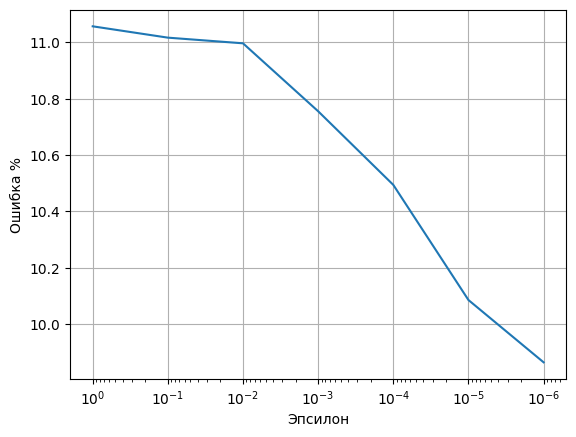

gisette_scale


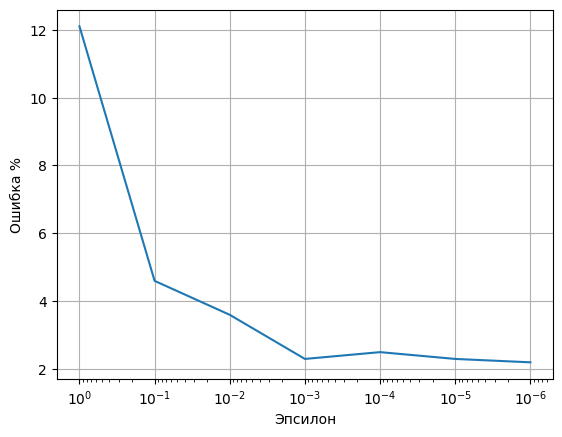

In [19]:
experiment_5()